In [1]:
import aplpy
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import astropy.table as Table
from astropy.io import ascii
from scipy.interpolate import interp1d

plt.rcParams.update({'font.size':12})

## LOS Velocity

In [2]:
def losVel(func, lam, apCen):
    return (func(apCen)-lam)/func(apCen) * 3e5

## Graphing Peaks

In [3]:
def addPeak(apCent,peak,figname,offset,right=False,col='r',fontcol='w'):
    if right:
        sign=1
        align='left'
    elif not right:
        sign=-1
        align='right'

    figname.add_label(peak+3*sign,apCent+offset,r'$\lambda = %s \AA$'%peak,horizontalalignment=align,color=fontcol)
    return

## Interpolation

In [4]:
def genInterp(galData):
    if len(galData) > 3:
        kind = 'cubic'
    else:
        kind = 'quadratic'
    
    apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center'])+1,1)
    fg = interp1d(galData['Aperture Center'],galData['Peak (Gaussian)'],kind=kind,fill_value='extrapolate')
    fm = interp1d(galData['Aperture Center'],galData['Peak (Maximum)'],kind=kind,fill_value='extrapolate')
    
    return fg, fm

## Polynomial Fit

In [5]:
def genPoly(galData):
    zG = np.polyfit(galData['Aperture Center'],galData['Peak (Gaussian)'],3)
#     zM = np.polyfit(galData['Aperture Center'],galData['Peak (Maximum)'],3)
    
    pG = np.poly1d(zG)
#     pM = np.poly1d(zM)
    
    return pG #, pM

In [6]:
def polystr(k):
    string = ''
    for i in range(len(k)):
        if i < len(k) - 1:
            string += '%.3f x^'%(k[i]) + str(len(k)-i-1) + ' + '
        else:
            string += '%.3f'%(k[i])
    return string

## Plot FITS

In [7]:
def subpltFITS(fig,name,centerCoord,offset,galData,conData,kind,maxP,w,h,multi,sub=1,BR='B',num='1'):
    filepath = 'SN_Images/%s/%s_0%s_%s.fits'%(name,name,num,BR)
    apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center']),1)
    
    if multi:
        tname=name+"_0"+num
    elif not multi:
        tname=name
    
    if sub == 1:
        subCoords = [0.05,0.05,0.9,0.9]
        titleType = 'Gaussian'
#         f = interp1d(galData['Aperture Center'],galData['Peak (Gaussian)'],kind=kind)
        f = genPoly(galData)#[0]
        fArr = np.vstack((f(apSpace),apSpace+offset))
        conLam = 'Peak (Gaussian)'
#     elif sub == 2:
#         subCoords = [0.55,0.05,0.425,0.9]
#         titleType = 'Maximum'
# #         f = interp1d(galData['Aperture Center'],galData['Peak (Maximum)'],kind=kind)
#         f = genPoly(galData)[1]
#         fArr = np.vstack((f(apSpace),apSpace+offset))
#         conLam = 'Peak (Maximum)'
    
    subplt = aplpy.FITSFigure(filepath,figure=fig,subplot=subCoords)
    subplt.recenter(centerCoord[0],centerCoord[1],width=w,height=h)
    subplt.show_grayscale(stretch='power',pmax=maxP)
    subplt.set_title('%s - %s - %.2f km/s Offset'%(tname,titleType,losVel(f,conData[conLam],conData['Aperture Center'])))
    subplt.axis_labels.set_xtext(r'Peak H$\alpha$ Wavelength ($\AA$)')
    subplt.axis_labels.set_ytext('Aperture Center (pix)')
    
    subplt.show_markers(fArr[0,:],fArr[1,:],marker='.',edgecolor='orange')
    
    for line in galData:
        addPeak(line['Aperture Center'],line[conLam],subplt,offset)
    
    addPeak(conData['Aperture Center'],conData[conLam],subplt,offset,col='k',fontcol='k')
    
    subplt.show_markers(galData[conLam],galData['Adjusted Aperture'],marker='o',s=50,edgecolor=None,facecolor='r')
    subplt.show_markers(conData[conLam],conData['Adjusted Aperture'],marker='*',s=150,edgecolor=None,facecolor='r')
    
    return



def pltFITS(name,centerCoord,offset,maxP=99,w=25,h=160,BR='B',num='1',multi=False):
    if multi:
        dataTable = ascii.read('SN_Images/%s/%s_0%s.csv'%(name,name,num))

    elif not multi:
        dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))

    dataTable['Adjusted Aperture'] = dataTable['Aperture Center'] + offset
    
    galData = dataTable[1:]
    conData = dataTable[0]
    
    if len(galData) > 3:
        kind = 'cubic'
    else:
        kind = 'quadratic'
    
    fig = plt.figure(figsize=(10,9),facecolor='w')
    
    subpltFITS(fig,name,centerCoord,offset,galData,conData,kind,maxP,w,h,multi,sub=1,BR=BR,num=num)
#     subpltFITS(fig,name,centerCoord,offset,galData,conData,kind,maxP,w,h,multi,sub=2,BR=BR,num=num)
    
    if multi:
        fig.savefig('SN_Images/%s/%s_0%s.png'%(name,name,num),facecolor=fig.get_facecolor())
    elif not multi:    
        fig.savefig('SN_Images/%s/%s.png'%(name,name),facecolor=fig.get_facecolor())
    fig.show()
    return

## Plot Interpolations

In [8]:
def pltInterp(name,offset,num='1',multi=False):
    if multi:
        dataTable = ascii.read('SN_Images/%s/%s_0%s.csv'%(name,name,num))
        tname = name+"_0"+num
    elif not multi:
        dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))
        tname=name
    dataTable['Adjusted Aperture'] = dataTable['Aperture Center'] + offset
    
    galData = dataTable[1:]
    conData = dataTable[0]
    
    if len(galData) > 3:
        kind = 'cubic'
    else:
        kind = 'quadratic'
    
    apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center'])+1,1)
    fg = interp1d(galData['Aperture Center'],galData['Peak (Gaussian)'],kind=kind,fill_value='extrapolate')
#     fgArr = np.vstack((fg(apSpace),apSpace+offset))
#     fm = interp1d(galData['Aperture Center'],galData['Peak (Maximum)'],kind=kind,fill_value='extrapolate')
#     fmArr = np.vstack((fm(apSpace),apSpace+offset))
    
    fig = plt.figure(figsize=(15,7),facecolor='w')
    
    fig.add_subplot(1,2,1)
    plt.title('%s - Gaussian - %.2f km/s Offset'%(tname,losVel(fg,conData['Peak (Gaussian)'],conData['Aperture Center'])))
    plt.ylabel('Aperture Center (px)')
    plt.xlabel(r'Peak H$\alpha$ Wavelength ($\AA$)')
    
    plt.scatter(galData['Peak (Gaussian)'],galData['Aperture Center'])
    plt.plot(fg(apSpace),apSpace,'--',label='Interpolation')
    plt.scatter(conData['Peak (Gaussian)'],conData['Aperture Center'],label=name)
    plt.scatter(fg(conData['Aperture Center']),conData['Aperture Center'],edgecolor='C1',c='w')
    plt.plot(np.linspace(float(min(conData['Peak (Gaussian)'],fg(conData['Aperture Center']))),
                float(max(conData['Peak (Gaussian)'],fg(conData['Aperture Center']))),50),
                [conData['Aperture Center']]*50,ls='--',c='C1')
    plt.legend()
    
    fig.add_subplot(1,2,2)
    plt.title('%s - Maximum - %.2f km/s Offset'%(tname,losVel(fm,conData['Peak (Maximum)'],conData['Aperture Center'])))
    plt.xlabel('Aperture Center (px)')
    plt.ylabel(r'Peak H$\alpha$ Wavelength ($\AA$)')
    
    plt.scatter(galData['Peak (Maximum)'],galData['Aperture Center'])
    plt.plot(fm(apSpace),apSpace,'--',label='Interpolation')
    plt.scatter(conData['Peak (Maximum)'],conData['Aperture Center'],label=name)
    plt.scatter(fm(conData['Aperture Center']),conData['Aperture Center'],edgecolor='C1',c='w')
    plt.plot(np.linspace(float(min(conData['Peak (Maximum)'],fm(conData['Aperture Center']))),
                float(max(conData['Peak (Maximum)'],fm(conData['Aperture Center']))),50),
                [conData['Aperture Center']]*50,ls='--',c='C1')
    plt.legend()
    
    plt.tight_layout()
    
    if multi:
        plt.savefig('SN_Images/%s/%s_0%s_interp.png'%(name,name,num),facecolor=fig.get_facecolor())
    elif not multi:
        plt.savefig('SN_Images/%s/%s_interp.png'%(name,name),facecolor=fig.get_facecolor())

## Plot Polynomial Fit

In [9]:
def pltPoly(name,offset,num='1',multi=False):
    if multi:
        dataTable = ascii.read('SN_Images/%s/%s_0%s.csv'%(name,name,num))
        tname = name+"_0"+num
    elif not multi:
        dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))
        tname=name
    dataTable['Adjusted Aperture'] = dataTable['Aperture Center'] + offset
    
    galData = dataTable[1:]
    conData = dataTable[0]
    
    apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center'])+1,1)
    
#     pg, pm = genPoly(galData)
    
    pg = genPoly(galData)
    
    fig = plt.figure(figsize=(10,9),facecolor='w')
    
    fig.add_subplot(1,1,1)
    plt.title('%s - Gaussian - %.2f km/s Offset'%(tname,losVel(pg,conData['Peak (Gaussian)'],conData['Aperture Center'])))
    plt.ylabel('Aperture Center (px)')
    plt.xlabel(r'Peak H$\alpha$ Wavelength ($\AA$)')
    
    plt.scatter(galData['Peak (Gaussian)'],galData['Aperture Center'])
    plt.plot(pg(apSpace),apSpace,'--',label='Polynomial Fit')
    plt.scatter(pg(conData['Aperture Center']),conData['Aperture Center'],edgecolor='C1',c='w')
    plt.scatter(conData['Peak (Gaussian)'],conData['Aperture Center'],label=name)
    plt.plot(np.linspace(float(min(conData['Peak (Gaussian)'],pg(conData['Aperture Center']))),
                float(max(conData['Peak (Gaussian)'],pg(conData['Aperture Center']))),50),
                [conData['Aperture Center']]*50,ls='--',c='C1')
    plt.legend()
    
#     fig.add_subplot(1,2,2)
#     plt.title('%s - Maximum - %.2f km/s Offset'%(tname,losVel(pm,conData['Peak (Maximum)'],conData['Aperture Center'])))
#     plt.xlabel('Aperture Center (px)')
#     plt.ylabel(r'Peak H$\alpha$ Wavelength ($\AA$)')
    
#     plt.scatter(galData['Peak (Maximum)'],galData['Aperture Center'])
#     plt.plot(pm(apSpace),apSpace,'--',label='Polynomial Fit')
#     plt.scatter(conData['Peak (Maximum)'],conData['Aperture Center'],label=name)
#     plt.scatter(pm(conData['Aperture Center']),conData['Aperture Center'],edgecolor='C1',c='w')
#     plt.plot(np.linspace(float(min(conData['Peak (Maximum)'],pm(conData['Aperture Center']))),
#                 float(max(conData['Peak (Maximum)'],pm(conData['Aperture Center']))),50),
#                 [conData['Aperture Center']]*50,ls='--',c='C1')
#     plt.legend()
    
    plt.tight_layout()
    
    if multi:
        plt.savefig('SN_Images/%s/%s_0%s_poly.png'%(name,name,num),facecolor=fig.get_facecolor())
    elif not multi:
        plt.savefig('SN_Images/%s/%s_poly.png'%(name,name),facecolor=fig.get_facecolor())

## Plot Spectrum

In [10]:
def pltSpec(name,BR='B',num='1',multi=False,winWidth=50):
    from astropy.io import fits
    
    FITSfile = fits.open('SN_Images/%s/s%s_0%s_%s_c.ms.fits'%(name,name,num,BR))
    head = FITSfile[0].header
    data = FITSfile[0].data
    
    x0 = head['CRVAL1']
    dx = head['CD1_1']
    xL = head['NAXIS1']
    
    if BR == 'B':
        maxF = max(data[-2000:])
    elif BR == 'R':
        maxF = max(data[:-2000])
    
    lamRange = np.arange(x0,dx*xL+x0,dx)[:xL]
    
    if multi:
        dataTable = ascii.read('SN_Images/%s/%s_0%s.csv'%(name,name,num))
        tname = name+"_0"+num
    elif not multi:
        dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))
        tname=name
        
    dataTable['Adjusted Aperture'] = dataTable['Aperture Center']
    galData = dataTable[:-1]
    conData = dataTable[-1]
    
    fg, fm = genInterp(galData)
    pg, pm = genPoly(galData)
    
    fig = plt.figure(figsize=(10,9),facecolor='w')
    fig.add_subplot(1,2,1)
    plt.title('%s - Gaussian - %.2f km/s Offset'%(tname,losVel(pg,conData['Peak (Gaussian)'],conData['Aperture Center'])))
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim(conData['Peak (Gaussian)'] - winWidth/2, conData['Peak (Gaussian)'] + winWidth/2)
    plt.ylim(0,maxF*1.1)
    
    plt.plot(lamRange,data)
# #     plt.scatter(conData['Peak (Maximum)'],maxF,c='C1',label='Maximum Flux')
    plt.axvline(conData['Peak (Gaussian)'],c='C2',label='Peak')
#     plt.axvline(fg(conData['Aperture Center']),ls='--',c='C2',label='Interpolated (Gaussian)')
    plt.axvline(pg(conData['Aperture Center']),ls='--',c='C2',label='Polynomial Fit')
    plt.legend()
    
    fig.add_subplot(1,2,2)
    plt.title('%s - Maximum - %.2f km/s Offset'%(tname,losVel(pm,conData['Peak (Maximum)'],conData['Aperture Center'])))
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim(conData['Peak (Gaussian)'] - winWidth/2, conData['Peak (Gaussian)'] + winWidth/2)
    plt.ylim(0,maxF*1.1)
    plt.plot(lamRange,data)
    plt.axvline(conData['Peak (Maximum)'],c='C1',label='Peak')
#     plt.axvline(fm(conData['Aperture Center']),ls='-.',c='C1',label='Interpolated (Maximum)')
    plt.axvline(pm(conData['Aperture Center']),ls='-.',c='C1',label='Polynomial Fit')
    plt.legend()
    
    
    plt.tight_layout()
    
    if multi:
        plt.savefig('SN_Images/%s/%s_0%s_spec.png'%(name,name,num),facecolor=fig.get_facecolor())
    elif not multi:    
        plt.savefig('SN_Images/%s/%s_spec.png'%(name,name),facecolor=fig.get_facecolor())
    
    plt.show()

## Plot All

In [11]:
def pltAll(name,centerCoord,offset,maxP=99,w=10,h=160,BR='B',num='1',multi=False,winWidth=50):
    pltFITS(name,centerCoord,offset,maxP=maxP,w=w,h=h,BR=BR,num=num,multi=multi)
#     pltInterp(name,offset,num=num,multi=multi)
    pltPoly(name,offset,num=num,multi=multi)
#     pltSpec(name,BR=BR,num=num,multi=multi,winWidth=winWidth)

## Plots

/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  


INFO: Auto-setting vmin to -2.289e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.102e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned


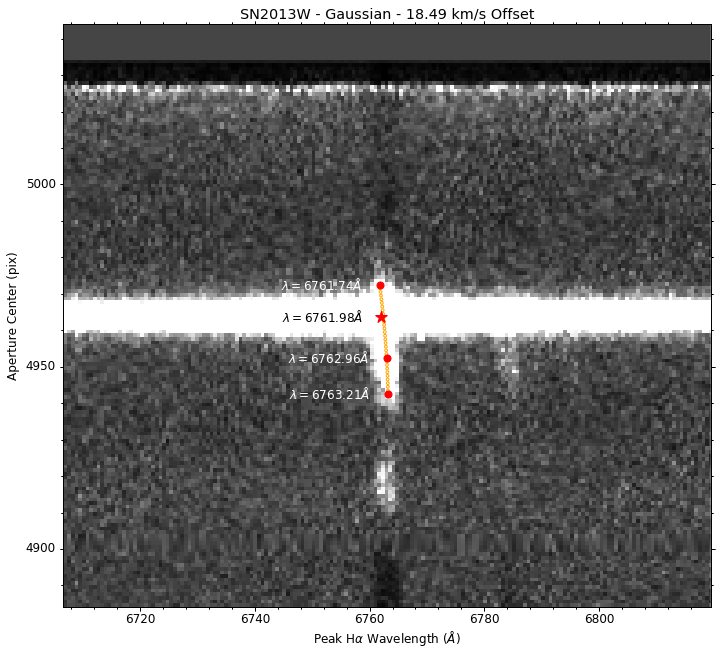

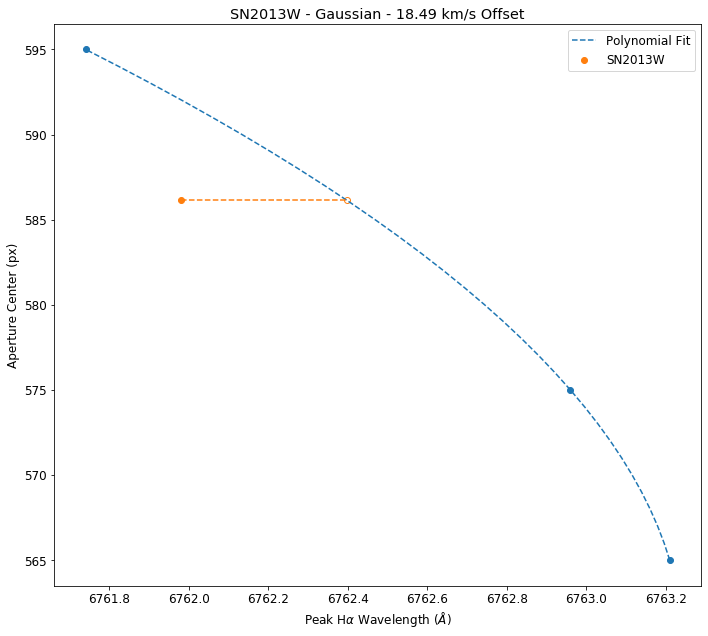

In [12]:
pltAll("SN2013W",(6763,4964),4377.5,maxP=99.25)

/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  


INFO: Auto-setting vmin to -7.488e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.332e+02 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned


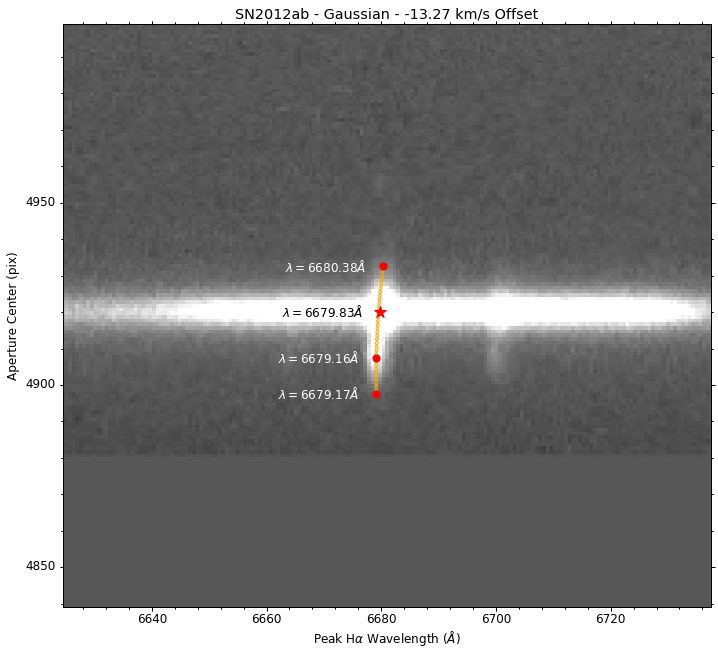

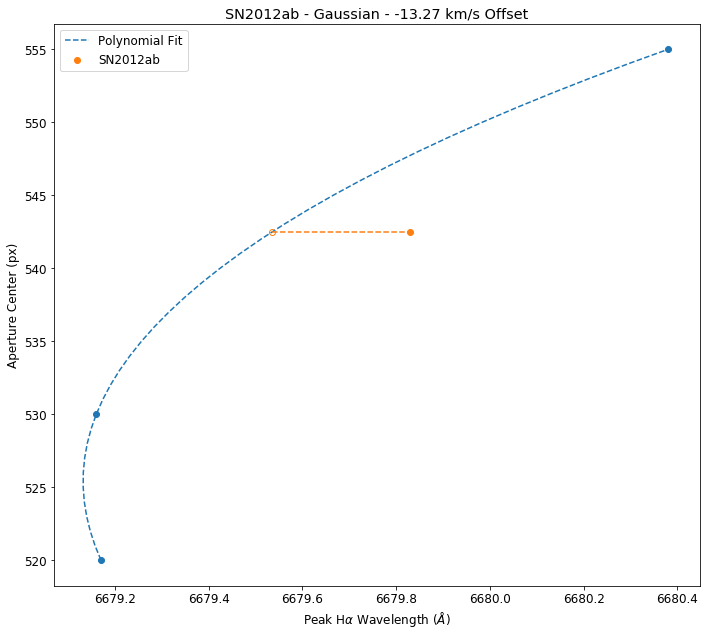

In [13]:
pltAll("SN2012ab",(6681,4919),4377.5,maxP=99.99)

INFO: Auto-setting vmin to -3.579e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.227e+02 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


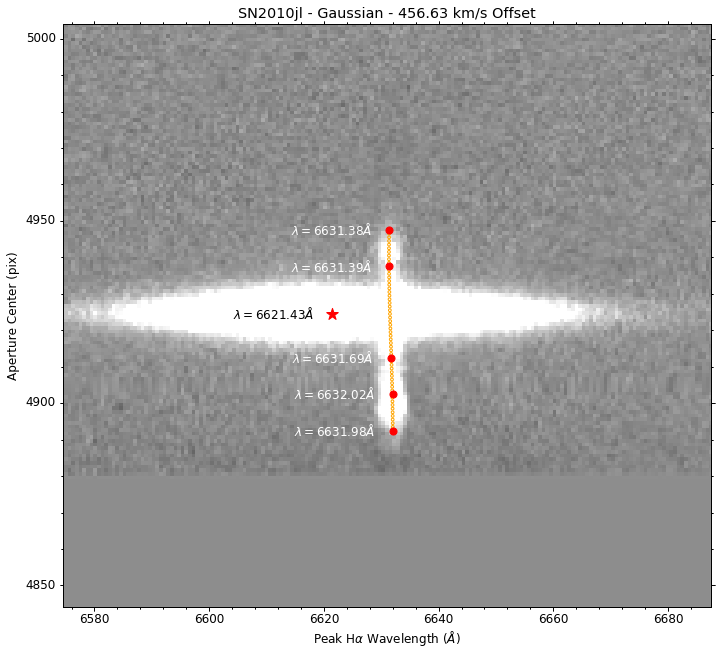

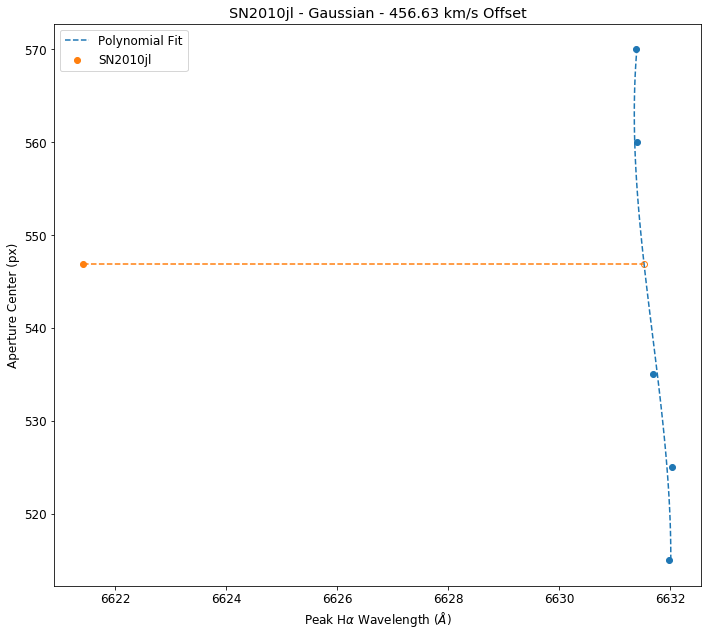

In [14]:
pltAll("SN2010jl",(6631,4924),4377.5,maxP=99.97)

INFO: Auto-setting vmin to -1.340e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.319e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


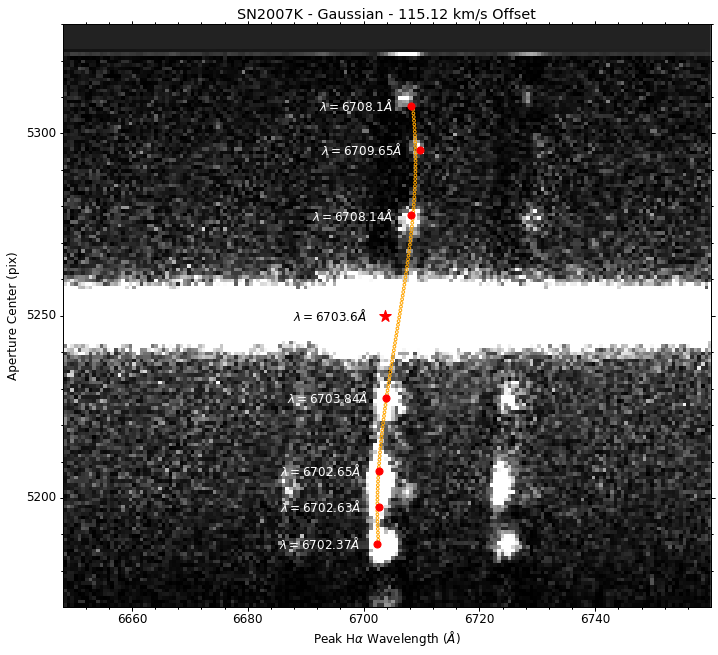

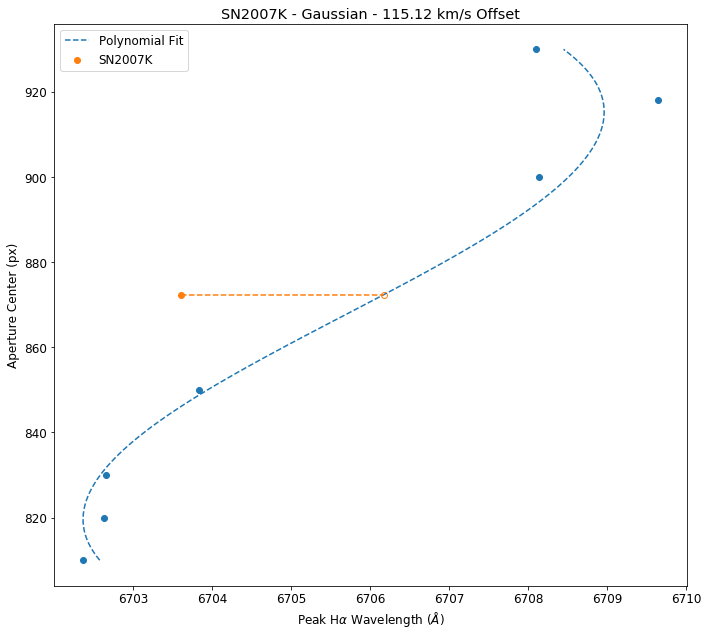

In [15]:
pltAll("SN2007K",(6704,5250),4377.5,maxP=98.75)

INFO: Auto-setting vmin to -1.513e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.043e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


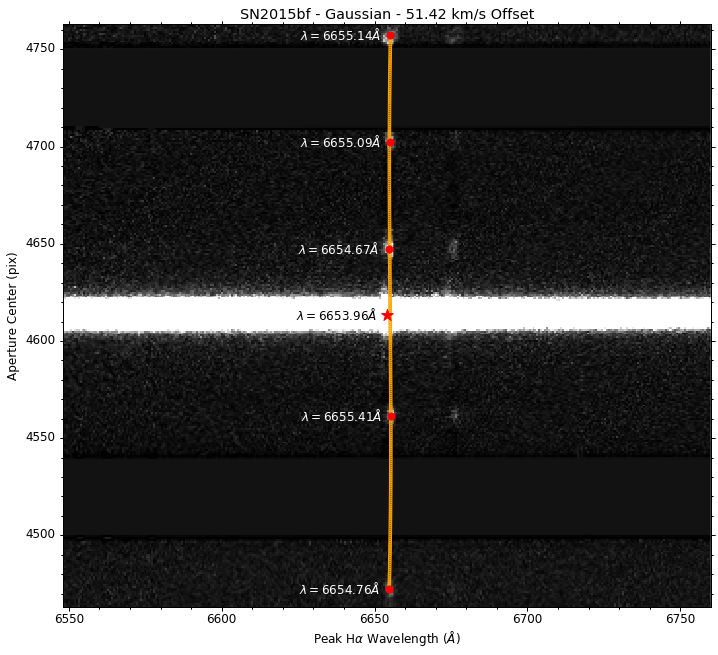

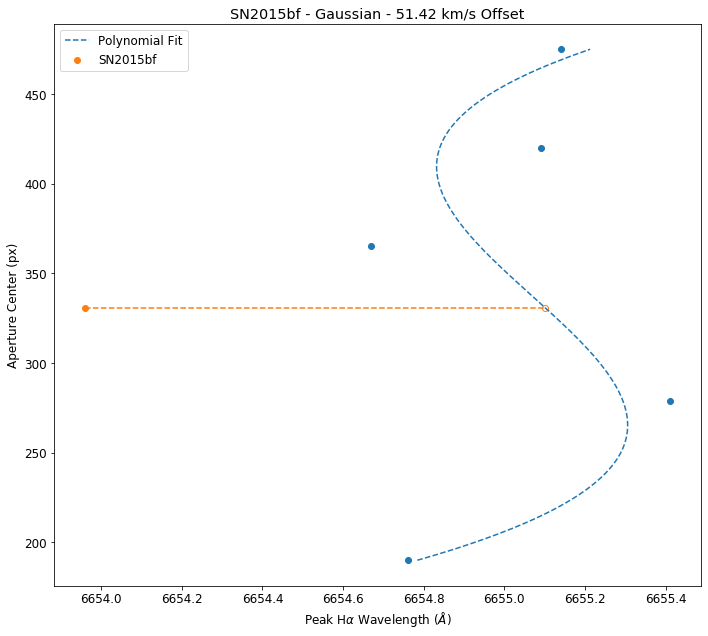

In [16]:
pltAll("SN2015bf",(6654,4613),4282.50,h=300,maxP=98.75)

INFO: Auto-setting vmin to -2.215e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.995e+02 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


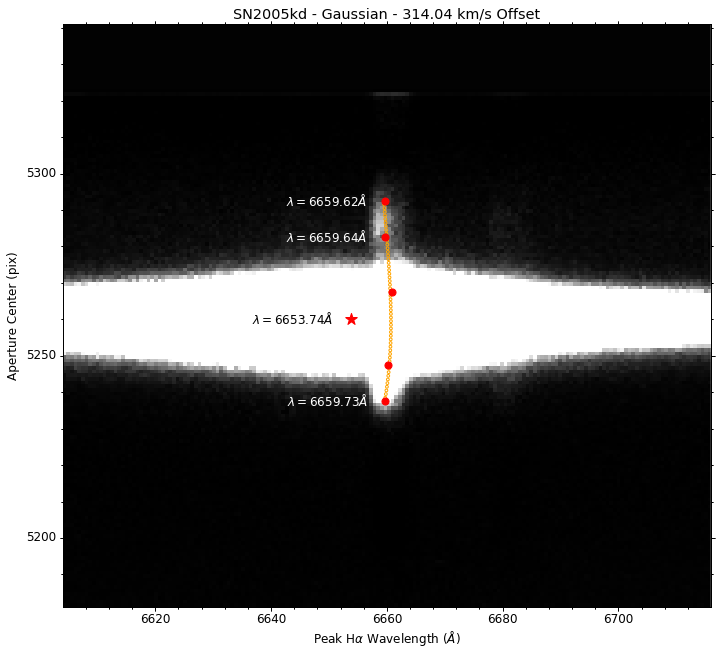

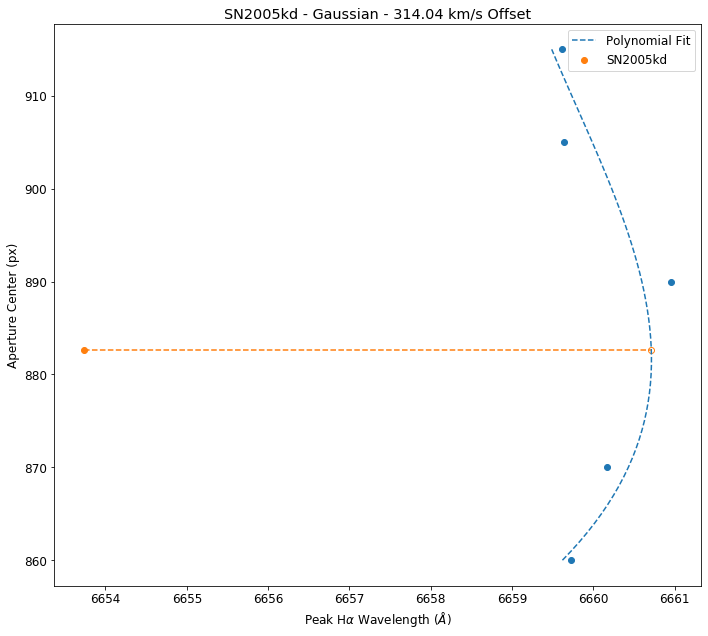

In [17]:
pltAll("SN2005kd",(6660,5261),4377.50,maxP=99.75)

INFO: Auto-setting vmin to -9.576e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.448e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


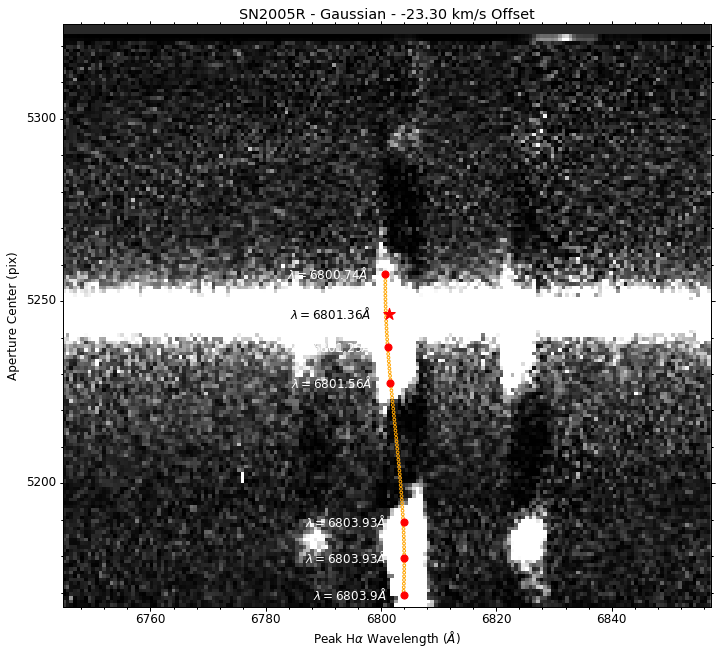

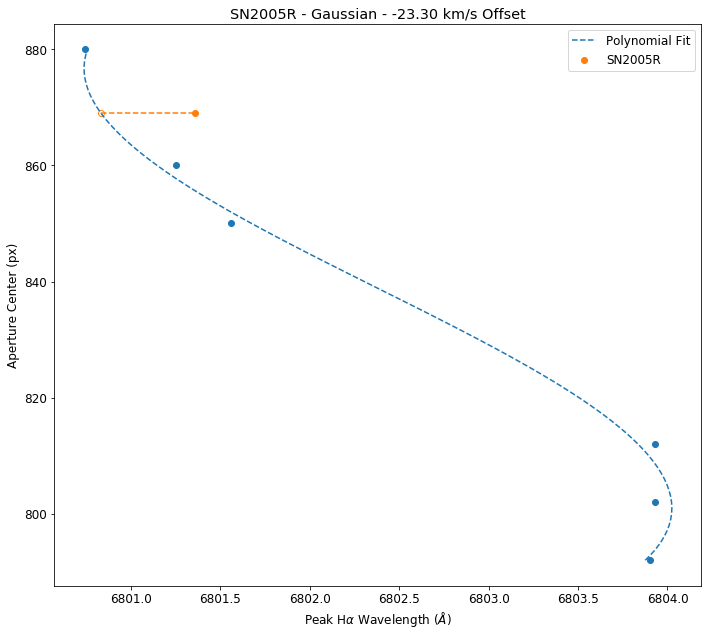

In [18]:
pltAll("SN2005R",(6801,5246),4377.50,maxP=98.75)

INFO: Auto-setting vmin to -7.861e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.005e+02 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


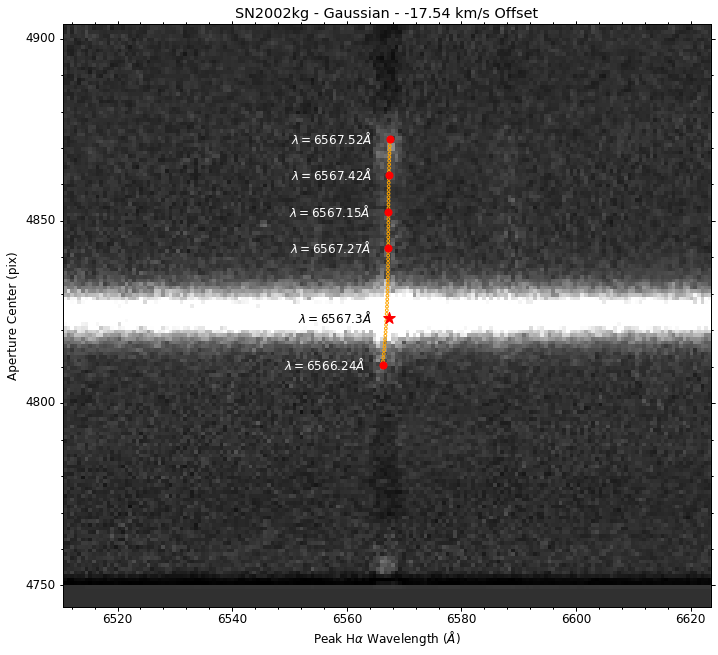

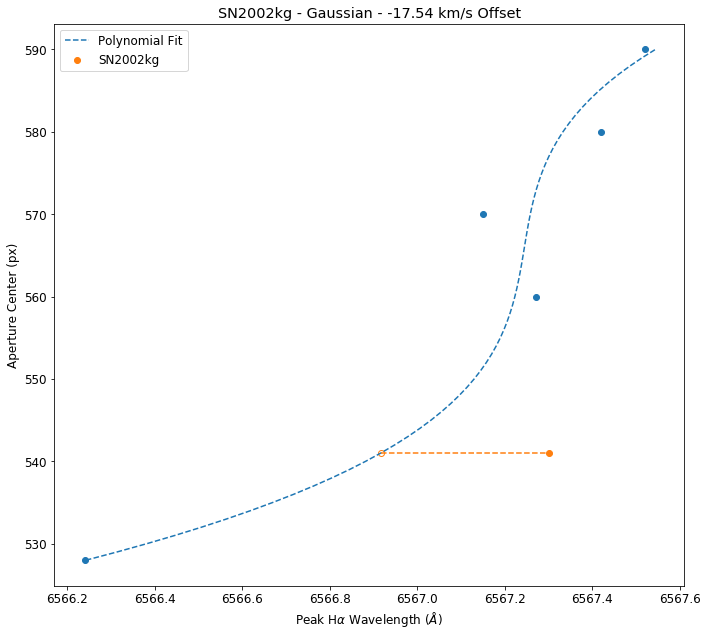

In [19]:
pltAll("SN2002kg",(6567,4824),4282.50,maxP=99.75)

INFO: Auto-setting vmin to -1.515e+01 [aplpy.core]
INFO: Auto-setting vmax to  9.500e+00 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


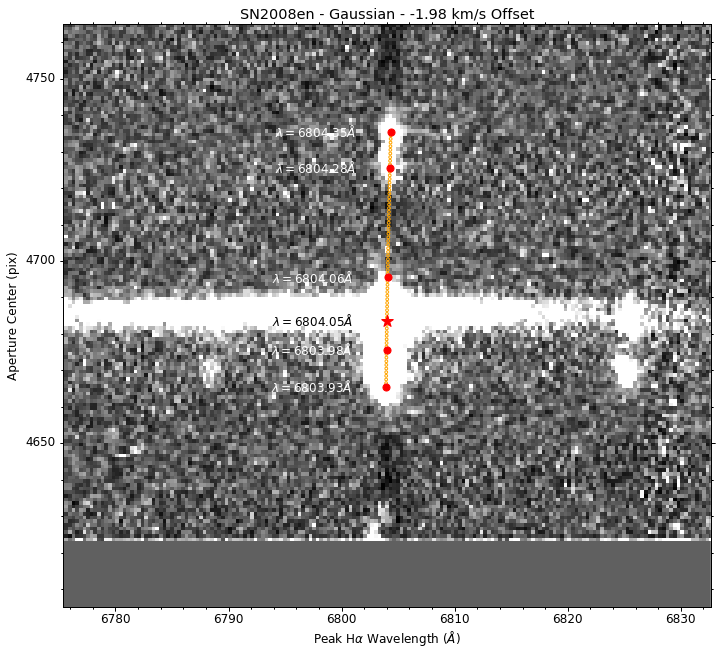

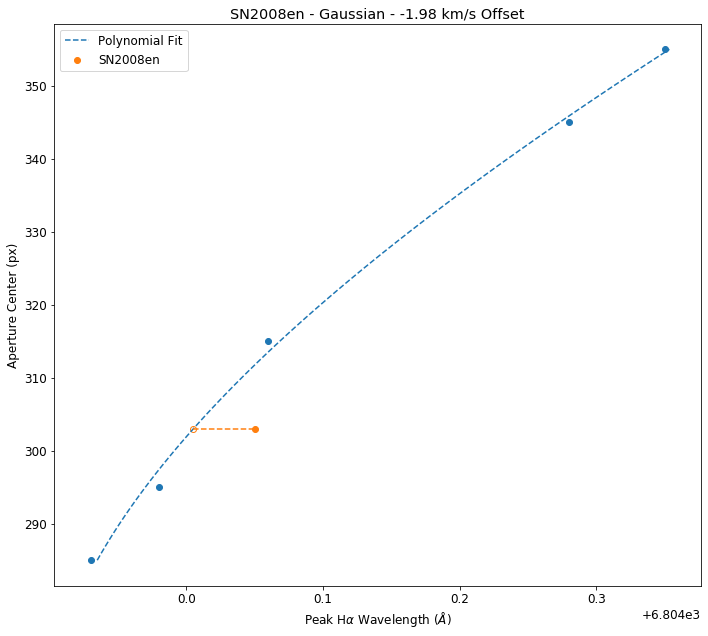

In [20]:
pltAll("SN2008en",(6804,4685),4380.50,BR='R',maxP=98.75)

INFO: Auto-setting vmin to -1.558e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.561e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


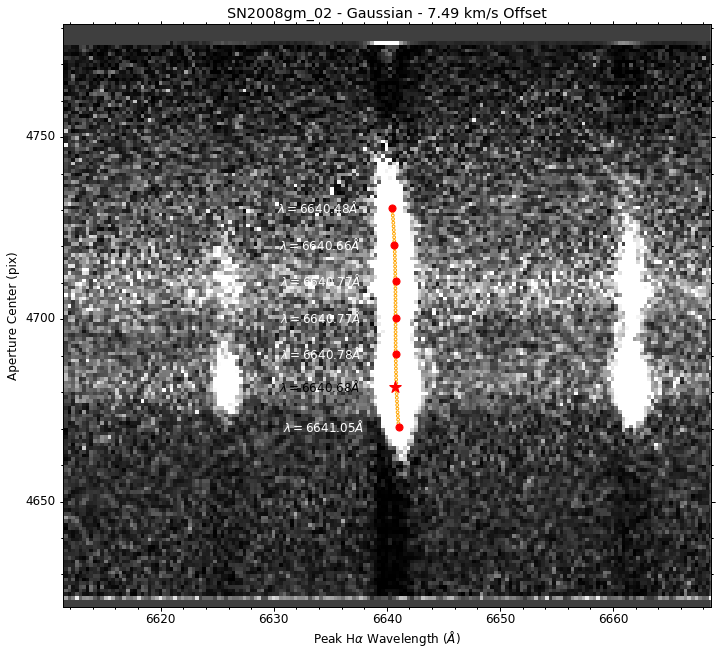

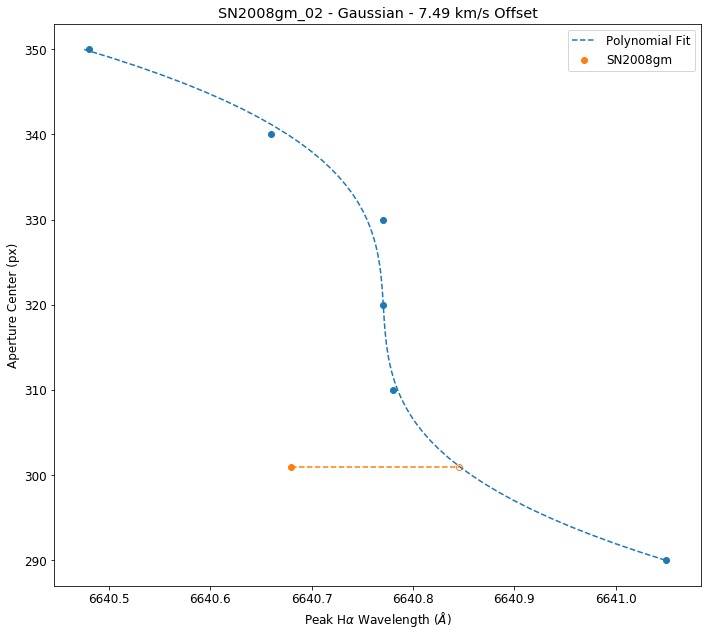

In [21]:
pltAll("SN2008gm",(6640,4701),4380.50,BR='R',num='2',multi=True,maxP=98.75)

INFO: Auto-setting vmin to -1.193e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.346e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


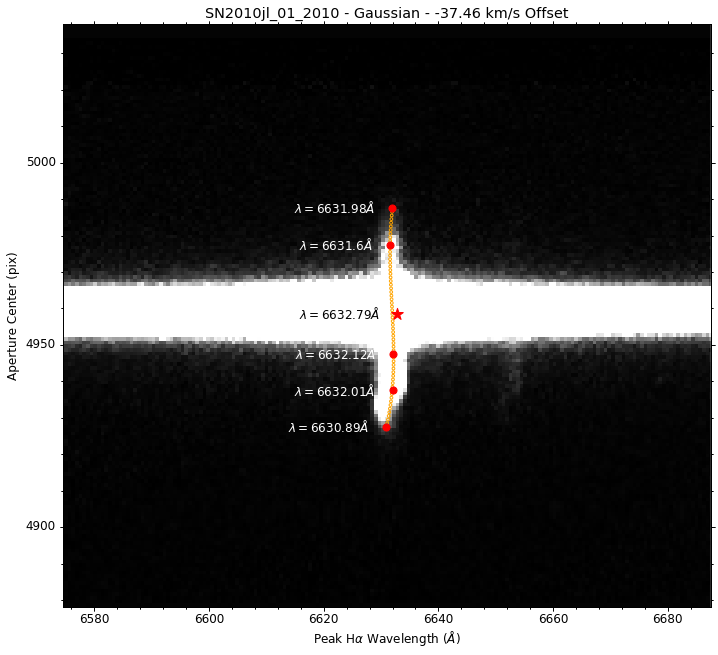

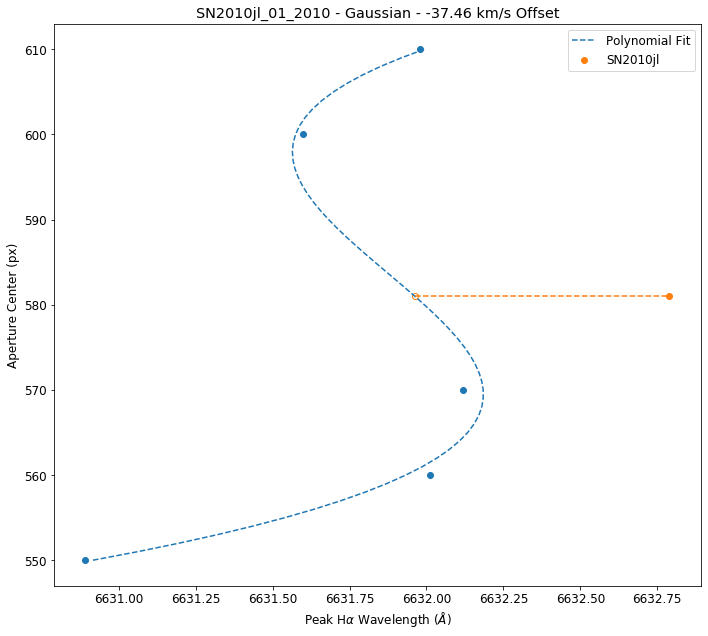

In [22]:
pltAll("SN2010jl",(6631,4958),4377.50,BR='B',num='1_2010',multi=True,maxP=98.75)

INFO: Auto-setting vmin to -1.419e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.373e+02 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


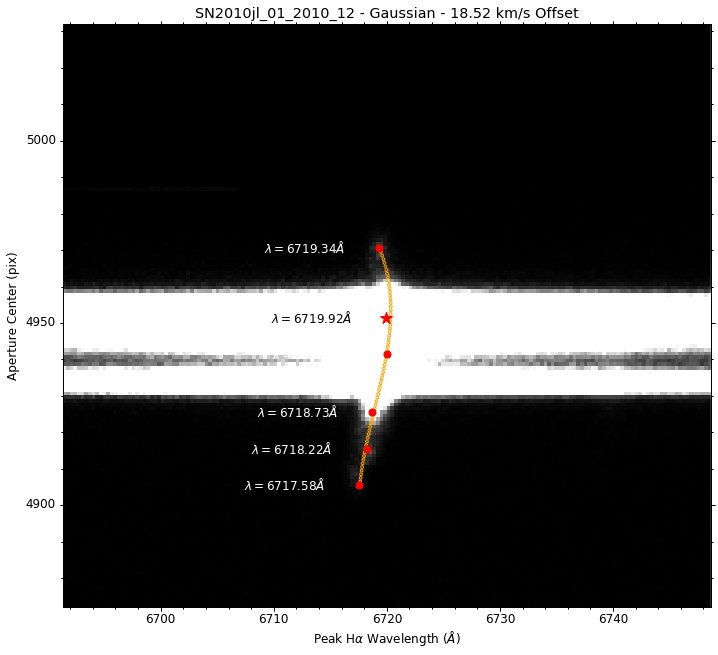

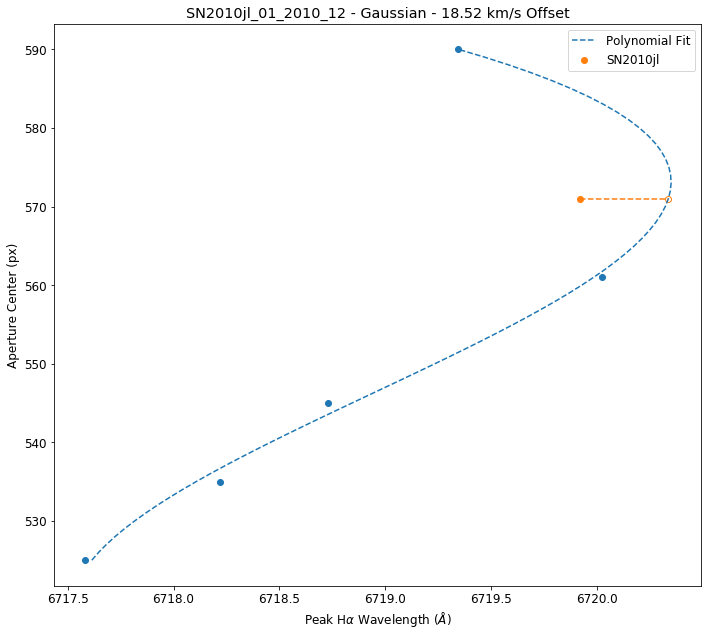

In [33]:
pltAll("SN2010jl",(6720,4952),4380.50,BR='R',num='1_2010_12',multi=True,maxP=98.75)

INFO: Auto-setting vmin to -1.083e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.133e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


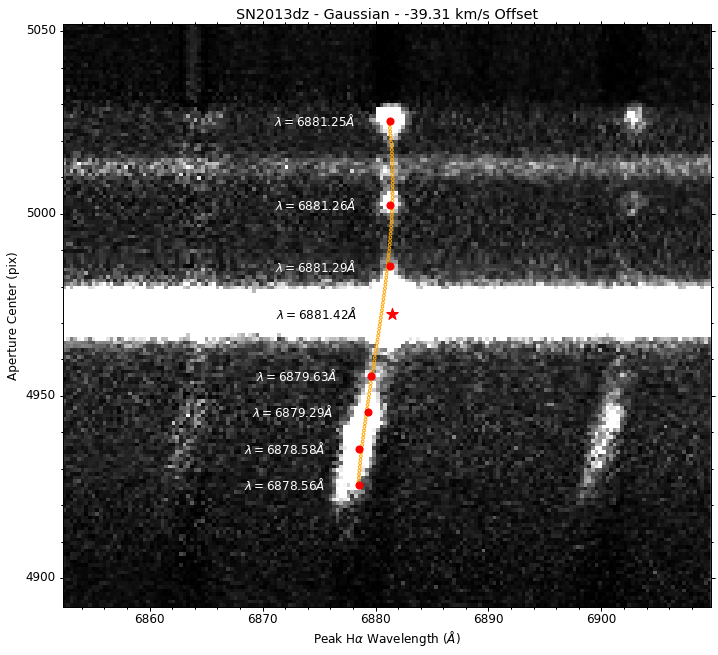

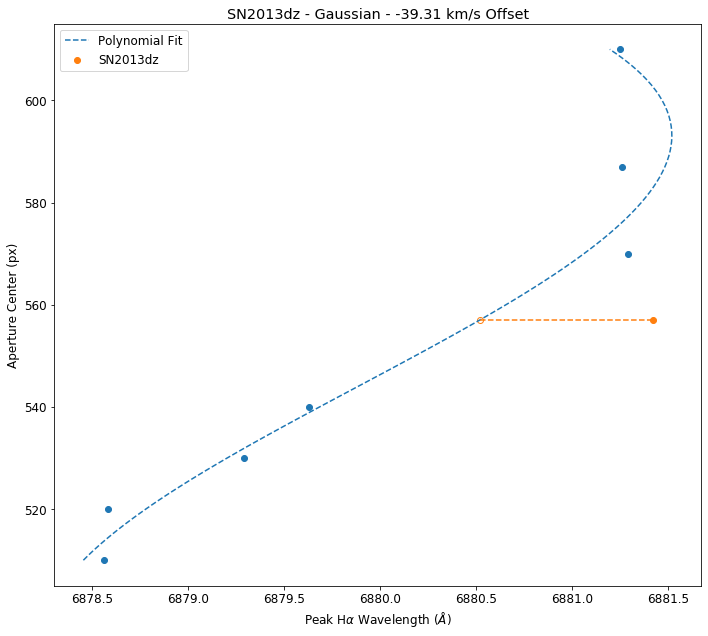

In [37]:
pltAll("SN2013dz",(6881,4972),4415.50,BR='R',maxP=98.75)